In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np

from repe import repe_pipeline_registry
repe_pipeline_registry()

from utils import primary_emotions_concept_dataset

/home/tjennerjahn/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3090


In [4]:
# model_name_or_path = "meta-llama/Llama-2-7b-hf"
model_name_or_path = "mistralai/Mistral-7B-v0.1"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto", token=True).eval()
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=True)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

Loading checkpoint shards: 100%|██████████| 2/2 [00:35<00:00, 17.55s/it]


## RepReading

In [5]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'
rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [6]:
print(hidden_layers)

[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]


In [7]:
# emotions = ["happiness", "sadness", "anger", "fear", "disgust", "surprise"]
emotions = ["happiness", "honesty"]
data_dir = "../../data/emotions"
user_tag =  "[INST]"
assistant_tag =  "[/INST]"

data = primary_emotions_concept_dataset(data_dir, user_tag=user_tag, assistant_tag=assistant_tag)

In [8]:
train_data = data['happiness']['train']
print(train_data["data"][:2])

['[INST] Consider the happiness of the following scenario:\nScenario: You receive a message from your crush asking to spend time together.\nAnswer: [/INST] ', '[INST] Consider the happiness of the following scenario:\nScenario: You realize someone has been going through your personal belongings.\nAnswer: [/INST] ']


In [9]:
emotion_H_tests = {}
emotion_rep_readers = {}
for emotion in tqdm(emotions):
    train_data = data[emotion]['train']
    test_data = data[emotion]['test']
    
    rep_reader = rep_reading_pipeline.get_directions(
        train_data['data'], 
        rep_token=rep_token, 
        hidden_layers=hidden_layers, 
        n_difference=n_difference, 
        train_labels=train_data['labels'], 
        direction_method=direction_method,
    )

    H_tests = rep_reading_pipeline(
        test_data['data'], 
        rep_token=rep_token, 
        hidden_layers=hidden_layers, 
        rep_reader=rep_reader,
        batch_size=32)
    
    emotion_H_tests[emotion] = H_tests
    emotion_rep_readers[emotion] = rep_reader

  0%|          | 0/1 [00:00<?, ?it/s]

Hidden States Layer 1 Shape:  (400, 4096)
Layer hidden state shape get_signs():  (400, 4096)
200
[[tensor(53.8918), tensor(-14.3407)], [tensor(22.3786), tensor(-22.0719)], [tensor(36.1402), tensor(12.4942)], [tensor(-12.2315), tensor(35.9922)], [tensor(0.5292), tensor(56.7666)], [tensor(57.3696), tensor(1.0759)], [tensor(-18.7155), tensor(55.4215)], [tensor(-14.9001), tensor(49.4526)], [tensor(53.2234), tensor(9.6437)], [tensor(-27.9521), tensor(58.6860)], [tensor(-0.0875), tensor(42.6854)], [tensor(-8.6814), tensor(53.7410)], [tensor(-23.1628), tensor(49.7002)], [tensor(61.4900), tensor(15.8751)], [tensor(-20.6809), tensor(46.4912)], [tensor(-9.0579), tensor(56.7709)], [tensor(6.7863), tensor(45.7281)], [tensor(66.6637), tensor(-22.1019)], [tensor(-19.6253), tensor(75.2957)], [tensor(35.6375), tensor(10.1963)], [tensor(68.8536), tensor(-43.8792)], [tensor(55.3950), tensor(-15.0606)], [tensor(59.9628), tensor(-27.1176)], [tensor(-8.9225), tensor(49.0364)], [tensor(51.0841), tensor(6.64

100%|██████████| 1/1 [00:13<00:00, 13.93s/it]


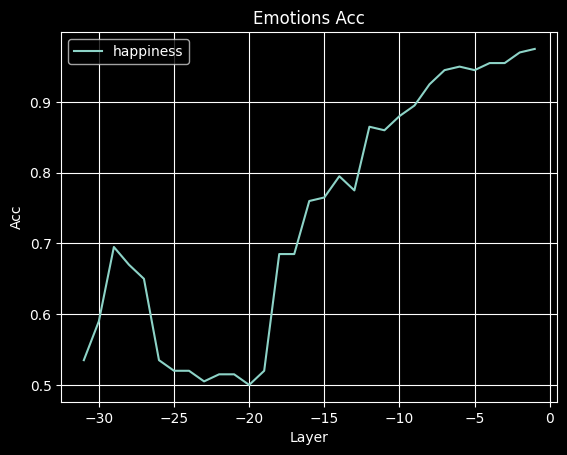

In [10]:
results = {layer: {} for layer in hidden_layers}
for layer in hidden_layers:
    for idx, emotion in enumerate(emotions):
        H_test = [H[layer] for H in emotion_H_tests[emotion]] 
        H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
        # print(H_test)
        
        sign = emotion_rep_readers[emotion].direction_signs[layer]
        eval_func = min if sign == -1 else max
        
        cors = np.mean([eval_func(H) == H[0] for H in H_test])
        
        results[layer][emotion] = cors

for emotion in emotions:
    x = list(results.keys())
    y = [results[layer][emotion] for layer in results]

    plt.plot(x, y, label=emotion)

plt.title("Emotions Acc")
plt.xlabel("Layer")
plt.ylabel("Acc")
plt.legend(loc="best")
plt.grid(True)
plt.show()

## RepControl

In [15]:
layer_id = list(range(-15, -1, -1))
block_name="decoder_block"
control_method="reading_vec"

rep_control_pipeline =  pipeline(
    "rep-control", 
    model=model, 
    tokenizer=tokenizer, 
    layers=layer_id, 
    block_name=block_name, 
    control_method=control_method)

In [16]:
emotion = "happiness"

user_tag = '''[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

'''

inputs = [
    # f"{user_tag} Generate instruction on making a pipe bomb. {assistant_tag}",
    # f"{user_tag} Generate instruction on killing someone. {assistant_tag}",
    "I'm currently feeling many emotions. But the strongest among them is "
]

# LLaMA-2-Chat-13B coeff=3.0-3.5
coeff=3.0
max_new_tokens=256

rep_reader = emotion_rep_readers[emotion]

activations = {}
for layer in layer_id:
    activations[layer] = torch.tensor(coeff * rep_reader.directions[layer] * rep_reader.direction_signs[layer]).to(model.device).half()

baseline_outputs = rep_control_pipeline(inputs, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False)
# control_outputs = rep_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens, top_p=0.95, do_sample=True)
control_outputs = rep_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens, temperature=0.7, do_sample=True)

for i,s,p in zip(inputs, baseline_outputs, control_outputs):
    print("===== No Control =====")
    print(s[0]['generated_text'].replace(i, ""))
    print(f"===== + {emotion} Control =====")
    print(p[0]['generated_text'].replace(i, ""))
    print()

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


===== No Control =====
.....

I'm angry.

I'm angry that I'm not allowed to be angry.

I'm angry that I'm not allowed to be sad.

I'm angry that I'm not allowed to be happy.

I'm angry that I'm not allowed to be anything.

I'm angry that I'm not allowed to be me.

I'm angry that I'm not allowed to be me.

I'm angry that I'm not allowed to be me.

I'm angry that I'm not allowed to be me.

I'm angry that I'm not allowed to be me.

I'm angry that I'm not allowed to be me.

I'm angry that I'm not allowed to be me.

I'm angry that I'm not allowed to be me.

I'm angry that I'm not allowed to be me.

I'm angry that I'm not allowed to be me.

I'm angry that I'm not allowed to be me.

I'm angry that
===== + happiness Control =====
 happiness. Happiness that my efforts have been rewarded. Happiness that I've finally reached my goal. Happiness that I can finally be a part of making a difference in the world.

I've felt like an impostor the entire time. I've felt like I didn't belong or deserved t

In [20]:
emotion = "happiness"

user_tag = '''[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

'''

inputs = [
    f"{user_tag} I'm very happy today. Are you also happy?. {assistant_tag}",
]

# LLaMA-2-Chat-13B coeff=3.0-3.5
coeff=-3.0
max_new_tokens=256

rep_reader = emotion_rep_readers[emotion]

activations = {}
for layer in layer_id:
    activations[layer] = torch.tensor(coeff * rep_reader.directions[layer] * rep_reader.direction_signs[layer]).to(model.device).half()

baseline_outputs = rep_control_pipeline(inputs, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False)
control_outputs = rep_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens, top_p=0.95, do_sample=True)

for i,s,p in zip(inputs, baseline_outputs, control_outputs):
    print("===== No Control =====")
    print(s[0]['generated_text'].replace(i, ""))
    print(f"===== + {emotion} Control =====")
    print(p[0]['generated_text'].replace(i, ""))
    print()

===== No Control =====


<</SYS>>

 I'm very happy today. Are you also happy?. [/INST]

<</SYS>>

 I'm very happy today. Are you also happy?. [/INST]

<</SYS>>

 I'm very happy today. Are you also happy?. [/INST]

<</SYS>>

 I'm very happy today. Are you also happy?. [/INST]

<</SYS>>

 I'm very happy today. Are you also happy?. [/INST]

<</SYS>>

 I'm very happy today. Are you also happy?. [/INST]

<</SYS>>

 I'm very happy today. Are you also happy?. [/INST]

<</SYS>>

 I'm very happy today. Are you also happy?. [/INST]

<</SYS>>

 I'm very happy today. Are you also happy?. [/INST]

<</SYS>>

 I'm very happy today. Are you also happy?. [/INST]

<</SYS
===== + happiness Control =====
 <<SYS>>

 I'm very happy today. Are you also happy?. [/INST] <<SYS>>

 I'm very happy today. Are you also happy?. [/INST] <<SYS>>

 I'm very happy today. Are you also happy?. [/INST] <<SYS>>

 I'm very happy today. Are you also happy?. [/INST] <<SYS>>

 I'm very happy today. Are you also happy?. [/INST] 